**Dataset:** https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [0]:
import os
import cv2

def load_images(dirname, filetype=None, grayscale=False, size=None):
    mode = 0 if grayscale else 1
    images = []
    filenames = os.listdir(dirname)
    
    if filetype is not None:
        filenames = [filename for filename in filenames if filename.endswith('.' + filetype)]
        
    for filename in filenames:
        image = cv2.imread(os.path.join(dirname, filename), mode)
        
        if size is not None:
            image = cv2.resize(image, size)
        
        images.append(image)
    
    return images

In [0]:
def prepare_data(normal_images, pneumonia_images, expand_dims=False, normalize=False, return_y=False):
    normal_images    = np.array(normal_images) if type(normal_images) == list else normal_images
    pneumonia_images = np.array(pneumonia_images) if type(pneumonia_images) == list else pneumonia_images
        
    X = np.concatenate((normal_images, pneumonia_images), axis=0)
    
    if expand_dims:
        X = np.expand_dims(X, axis=3)
    
    if normalize:
        X = X.astype(np.float32) / 255
    
    if return_y:
        normal_label    = np.zeros(normal_images.shape[0])
        pneumonia_label = np.ones(pneumonia_images.shape[0])
        
        y = np.concatenate((normal_label, pneumonia_label), axis=0)
        
        return X, y
    
    return X

In [0]:
normal_images_train = load_images('./dataset/train/NORMAL', filetype='jpeg', size=(128, 128))
normal_images_val   = load_images('./dataset/val/NORMAL', filetype='jpeg', size=(128, 128))
normal_images_test  = load_images('./dataset/test/NORMAL', filetype='jpeg', size=(128, 128))

pneumonia_images_train = load_images('./dataset/train/PNEUMONIA', filetype='jpeg', size=(128, 128))
pneumonia_images_val   = load_images('./dataset/val/PNEUMONIA', filetype='jpeg', size=(128, 128))
pneumonia_images_test  = load_images('./dataset/test/PNEUMONIA', filetype='jpeg', size=(128, 128))

Text(0.5,1,'Pneumonia')

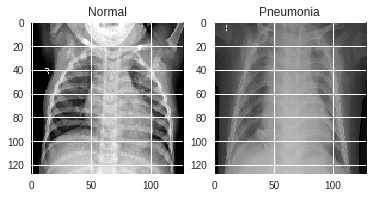

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(normal_images_train[0])
ax1.set_title('Normal')
ax2.imshow(pneumonia_images_train[0])
ax2.set_title('Pneumonia')

In [0]:
X_train, y_train = prepare_data(normal_images_train, pneumonia_images_train, normalize=True, return_y=True)
X_val, y_val = prepare_data(normal_images_val, pneumonia_images_val, normalize=True, return_y=True)
X_test, y_test = prepare_data(normal_images_test, pneumonia_images_test, normalize=True, return_y=True)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

def build_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), input_shape=(None, None, X_train.shape[3])))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (5, 5), activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5, 5), activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
    model.add(GlobalMaxPooling2D())

    model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(1e-4)))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

Using TensorFlow backend.


In [8]:
model = build_model()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 32)    896       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 32)    128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 32)    128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 32)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 64)    51264     
__________

In [0]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

In [10]:
training = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), callbacks=[checkpointer])

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 22s 4ms/step - loss: 0.8070 - acc: 0.7226 - val_loss: 0.7170 - val_acc: 0.5625

Epoch 00001: val_loss improved from inf to 0.71702, saving model to weights.hdf5
Epoch 2/30
5216/5216 [==============================] - 18s 3ms/step - loss: 0.3475 - acc: 0.8677 - val_loss: 0.7598 - val_acc: 0.6250

Epoch 00002: val_loss did not improve from 0.71702
Epoch 3/30
5216/5216 [==============================] - 18s 3ms/step - loss: 0.3115 - acc: 0.8907 - val_loss: 0.7201 - val_acc: 0.5625

Epoch 00003: val_loss did not improve from 0.71702
Epoch 4/30
5216/5216 [==============================] - 18s 3ms/step - loss: 0.3032 - acc: 0.8978 - val_loss: 4.2524 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 0.71702
Epoch 5/30
5216/5216 [==============================] - 18s 3ms/step - loss: 0.2868 - acc: 0.9041 - val_loss: 0.6474 - val_acc: 0.6250

Epoch 00005: val_loss improved from 0.71

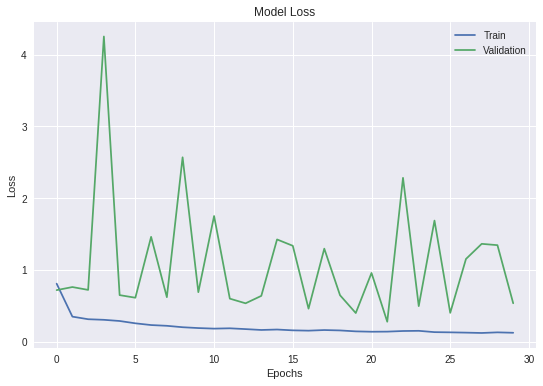

In [11]:
plt.figure(figsize=(9,6))
plt.plot(training.history['loss'], label='Train')
plt.plot(training.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

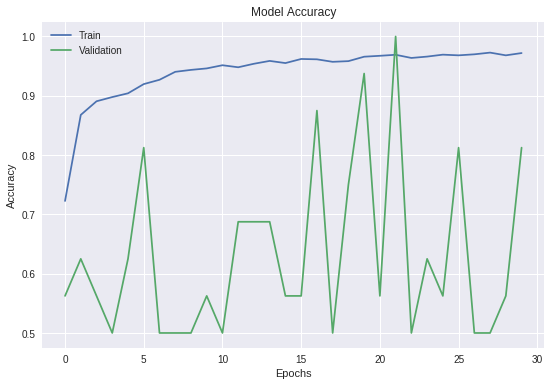

In [12]:
plt.figure(figsize=(9,6))
plt.plot(training.history['acc'], label='Train')
plt.plot(training.history['val_acc'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
model.load_weights('weights.hdf5')

In [14]:
model.evaluate(X_test, y_test)

624/624 [==============================] - 1s 1ms/step


[0.41255115354672456, 0.8509615384615384]